# Section C (KNN Classification)

## Dataset
This dataset is about 11 clinical features for predicting heart disease events, from Kaggle [Heart Failure Prediction Dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction/)

In [162]:
import pandas as pd
df = pd.read_csv("heart.csv", sep = ',')

The dataset has 918 observations and 12 features (11 independent features and 1 dependent feature)

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


There are no missing values in these dataset.

In [164]:
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


The target class distribution is relatively balanced.

In [165]:
df.iloc[:,-1].value_counts()/len(df.iloc[:,-1])

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

Split the dataset into Feature vectors (X) and labels (y)

In [166]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [167]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

### Convert categorical values

The dataset contains categorical variables like *ChestPainType*, since machine learning algorithms cannot work with categorical data directly, I use `get_dummies` function to convert the categorical values into numeric values by using one-hot code.

In [168]:
# Applying One hot Encoding on the Categorical columns
X=pd.get_dummies(X)
pd.DataFrame(X).head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


### Split dataset 
I split dataset into train dataset, validation dataset, and test dataset in the ratio 8:1:1. 

- Train dataset: Train dataset is used to fit the parameters to the model, or 'finding nearest neighbors'

- Validation dataset: Validation dataset is used to assess the model's performance and avoid overfitting (the model is really good at classifying the samples in the training dataset but cannot generalize and make accurate classifications on the unseen data), it helps us tune the model's hyperparameters, so we can improve the model according to the results on validation.

- Test dataset: Test dataset is used to assess the performance of the final chosen model.

In [169]:
from sklearn.model_selection import train_test_split
# Training dataset 80%, validation dataset 10%, test dataset 10%
# Split heart disease dataset into a remaining dataset and a test dataset,
# and split the remaining dataset into a training dataset and a validation dataset, use 'random_state' for data reproducibility.
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
X_train, X_validation, y_train, y_validation = train_test_split(X_remain, y_remain, test_size = 1/9,random_state = 0)

## Question 1: Explore the proportions of train and validation datasets
Explore how the performance of KNN model varies on both the train and the validation data change as I vary the amount of training data used.

### Change the proportion of the validation dataset
I define a function called `explore_proportion` to change the proportion of the validation dataset and try different values (11%, 18%, 24%, 31%, 38%, 44%) to split the train dataset and validation dataset.First, I set the hyperparameter k of the KNN model to 5. Then, I fit the model with the train dataset. Finally, I evaluated the performance of the KNN model based on the 'accuracy scores' on the train and validation datasets. For different divisions of the training and validation datasets, I repeat these steps above and plot a line graph to describe the trend.

In [170]:
import numpy as np
from sklearn.metrics import accuracy_score

explore_train_accuracy_score = []
explore_validation_accuracy_score = []
validation_proportion_list = []

def explore_proportion(validation_proportion):
    # Split the train and  validation datasets in different proportions
    X_train, X_validation, y_train, y_validation = train_test_split(X_remain, y_remain, test_size = validation_proportion, random_state = 3)
    
    # Train KNN model 
    knn_1 = KNeighborsClassifier(n_neighbors = 5)
    knn_1.fit(X_train, y_train)

    # How the model performs on the train and validation datasets
    y_train_pred = knn_1.predict(X_train) 
    train_explore_accuracy = round(accuracy_score(y_train,y_train_pred)*100,2)   
    y_validation_pred = knn_1.predict(X_validation) 
    validation_explore_accuracy = round(accuracy_score(y_validation,y_validation_pred)*100,2)

    # Use accuracy metrics to assess performance
    explore_train_accuracy_score.append(train_explore_accuracy)
    explore_validation_accuracy_score.append(validation_explore_accuracy)

# Change the proportion of the validation dataset
for validation_proportion in np.arange(1/9,1/2,1/15):
    validation_proportion_list.append(round(validation_proportion,2))
    explore_proportion(validation_proportion)
    
print(validation_proportion_list)

[0.11, 0.18, 0.24, 0.31, 0.38, 0.44]


### print the data

In [171]:

train_proportion_list = list(map(lambda x:1-x,validation_proportion_list))
# print(train_proportion_list)
# print(validation_proportion_list)
# print(explore_train_accuracy_score)
# print(explore_validation_accuracy_score)

train_validataion_ratio = [round(a / b,1) for a,b in zip(train_proportion_list,validation_proportion_list)]

df = pd.DataFrame({'train_proportion':train_proportion_list, 
                   'validation_proportion':validation_proportion_list,
                   'train_validation_ratio':train_validataion_ratio,
                   'train_accuracy_score':explore_train_accuracy_score,
                   'validation_accuracy_score':explore_validation_accuracy_score
                   })

df


,train_proportion,validation_proportion,train_validation_ratio,train_accuracy_score,validation_accuracy_score
0,0.89,0.11,8.1,78.47,72.83
1,0.82,0.18,4.6,77.91,74.15
2,0.76,0.24,3.2,77.08,73.76
3,0.69,0.31,2.2,76.10,71.60
4,0.62,0.38,1.6,76.02,69.97
5,0.56,0.44,1.3,75.98,69.57


### Line graph
I plot the `Accuracy score on train and validation datasets` line graph. As the amount of data used to train the model increases, the accuracy score for the train dataset increases, and the accuracy score for the validation dataset increases first and begins to decrease when the ratio of train/validation datasets exceeds 4.6.

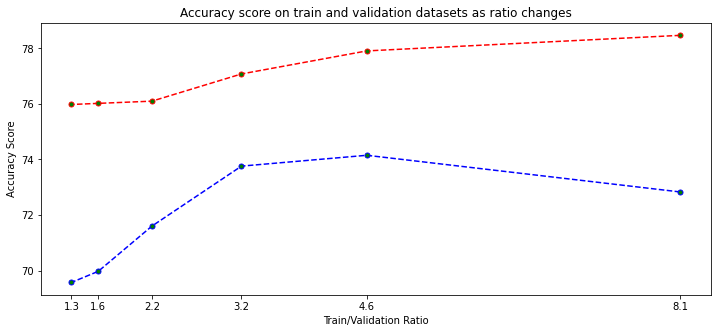

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train_validataion_ratio, explore_train_accuracy_score,marker = "o",markerfacecolor = "green", 
         linestyle = "dashed" ,color = "red",markersize = 5)
plt.plot(train_validataion_ratio, explore_validation_accuracy_score,marker = "o",markerfacecolor = "green", 
         linestyle = "dashed" ,color = "blue",markersize = 5)

plt.title('Accuracy score on train and validation datasets as ratio changes')
plt.xticks(list(map(lambda x:round(x,1),train_validataion_ratio)))
plt.xlabel('Train/Validation Ratio')
plt.ylabel('Accuracy Score')
plt.show()

## Question 2: Train, tune and test KNN model.
Explore how the performance of KNN model varies on both the train and the validation data change as I vary the hyperparameter K.

From the Question 1 I explored above, when train/validatoin datasets ratio is 4.6 (Except the test dataset, the train dataset counts 72% of the remainder dataset, validation dataset counts 18% of the remainder dataset), accuracy score is higher than other ratios. So for question 2, I choose the ratio to tune the hyperparameter k and try to find the best k based on the accuracy score for validation dataset. Finally, I plot the line graph for the accuracy score of train and validation dataset as I vary the value of hyperparameter K.

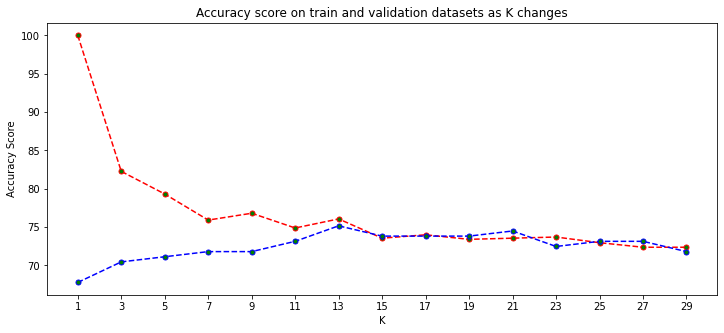

In [173]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_validation, y_train, y_validation = train_test_split(X_remain, y_remain, test_size = 0.18,random_state = 0)


# Set k to an odd value in the binary classification to avoid ties. 
k_range = list(range(1,30,2))
# Use a list to store how the accuracy socore varis as the k changes.
k_list = []
Q2_train_accuracy_score = []
Q2_validation_accuracy_score = []

# Train KNN model and tune the hyperparameter K
for k in k_range:
    
    knn_2 = KNeighborsClassifier(n_neighbors = k)
    knn_2.fit(X_train, y_train)
    
    y_train_pred = knn_2.predict(X_train) 
    y_validation_pred = knn_2.predict(X_validation) 
    
    Q2_train_explore_accuracy = round(accuracy_score(y_train,y_train_pred)*100,2)   
    Q2_validation_explore_accuracy = round(accuracy_score(y_validation,y_validation_pred)*100,2)
    
    Q2_train_accuracy_score.append(Q2_train_explore_accuracy)
    Q2_validation_accuracy_score.append(Q2_validation_explore_accuracy)
    k_list.append(k)

    

plt.figure(figsize=(12,5))

plt.plot(k_list, Q2_train_accuracy_score,marker = "o",markerfacecolor = "green", 
         linestyle = "dashed" ,color = "red",markersize = 5)
plt.plot(k_list, Q2_validation_accuracy_score,marker = "o",markerfacecolor = "green", 
         linestyle = "dashed" ,color = "blue",markersize = 5)

plt.title('Accuracy score on train and validation datasets as K changes')
plt.xticks(k_list)
plt.xlabel('K')
plt.ylabel('Accuracy Score')
plt.show()
                

### Test the KNN model on test dataset
I choose the optimal value of the hyperparameter K to be 13 based on the accuracy score of the validation dataset.  when K exceeds 13，the accuracy score of the validation dataset fluctuates in a small range. The accuracy of the model for classification in test dataset is 72.83%.

In [174]:
knn_2 = KNeighborsClassifier(n_neighbors = 13)
knn_2.fit(X_train, y_train)

y_test_pred=knn_2.predict(X_test) 
test_accuracy = accuracy_score(y_test,y_test_pred)*100
print('KNN_2 Test accuracy: %.2f%%' % test_accuracy)

KNN_2 Test accuracy: 72.83%


## Question 3: Explore Cross Validation
In order to get better understanding by using cross validation, I compare the accuracy score of two models trained by two methods for classification on the test dataset (method 1: splitting the train and validation datasets (in Question2) and method 2: using 10-folds cross-validation).


I use `GridSearchCV` function from `scikit-learn` library to find the optimal value for hyperparameter K that I tune.
There are four parameters I specify in this function: estimator, param_grid, scoring, cv. 

- estimator:  the model that I train
- Parameter `param_grid` to store the possible values for hyperparameter K. This method tries all the value for hyperparameter k, it trained on the train dataset and tune the k on validation dataset and records the model performance (accuracy score). Finally, it returns the optimal KNN model with the optimal value of hyperparameter K. Again, I use accuracy score to assess the performance of the model.

- Scoring: I choose `accuracy` to assess the model performance.  

- CV: I choose 10-folds cross validation as cross-validation splitting strategy. Here, the dataset is split into 10 folds. In the first iteration, the first fold is used to test the model on validation dataset and the rest are used to train the model. In the second iteration, second fold is used to the test the model while the rest of dataset serves as the train dataset. This process is repeated until each fold of the 10 folds have been used as the validation dataset to test the model. Then the 10 estimates for model performance are derived. The average of 10 estimates for model performance model performance is  the estimates for model performance.

In [175]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter K
k_range = list(range(1,31,2))
param_dict = dict(n_neighbors = k_range)

#Create KNN classiifier
knn_3 = KNeighborsClassifier()

#Use 10 fold cross-validation, use accuracy to evaluate the performance of the model on the validation set
grid = GridSearchCV(estimator = knn_3, param_grid = param_dict, scoring = 'accuracy', cv = 10) 

#Fit the model (remain dataset includes train and validation dataset that I split before.)
best_model = grid.fit(X_remain,y_remain) 

#Print the value of best hyperparameters and best accuracy score
print('best hyperparameters', best_model.best_params_)
print('accuracy_score : %.4f' % best_model.best_score_ )

best hyperparameters {'n_neighbors': 11}
accuracy_score : 0.7155


### Test KNN_3 on test dataset
The classification accuracy of KNN_3 is 76.09%, which is better than KNN_2, which is 72.83%.

In [176]:
y_test_pred=best_model.predict(X_test) 
test_accuracy = accuracy_score(y_test,y_test_pred)*100
print('KNN_3 Test accuracy: %.2f%%' % test_accuracy)

KNN_3 Test accuracy: 76.09%


## Qestion 4: Improve KNN performance

In order to improve the classification accuracy of this KNN model, first, I scale the features in the heart disease dataset to the same scaleand tune more hyperparameters(K,P,Weights)
### Feature Scaling
I use Data Standardization method to resclae the attributes so that they have mean as 0 and variance as 1, this can bring down all the features to a common scale without distorting the differences in the range of the values. I have imported `standard scaler` from `scikit-learn` library. I call fit_transform() method on our training and validation dataset and transform() method on the test dataset.

### Hyperparameters tuning
- k: The number of nearest neighbors.
- P: Choice of distance measure. When p = 1, this is equivalent to using manhattan_distance, and euclidean_distance for p = 2. For arbitrary p (eg. p=3), minkowski_distance is used.

- Weights: Weighting of the distance measure.
‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

After use Standaization, The accuracy increases.

In [177]:
from sklearn.preprocessing import StandardScaler

sc_x=StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_valid = sc_x.fit_transform(X_valid)
X_test=sc_x.transform(X_test)

In [178]:
from sklearn.model_selection import GridSearchCV

# Hyperparameters that we want to tune.
k_range = list(range(3,31,2))
weight_options = ["uniform", "distance"]
p_options=[1,2,3]

param_dict = dict(n_neighbors = k_range, weights = weight_options, p = p_options)

#Create KNN classiifier
knn_4 = KNeighborsClassifier()

#Use 5 fold cross-validation, use accuracy to evaluate the performance of the model on the validation set
grid = GridSearchCV(estimator = knn_4, param_grid = param_dict, scoring = 'accuracy', cv = 10) 

#Fit the model (remain dataset includes train and validation dataset that I split before.)
best_model = grid.fit(X_remain,y_remain) 

#Print the value of best hyperparameters and best accuracy score
print('best hyperparameters', best_model.best_params_)
print('accuracy_score : %.4f' % best_model.best_score_ )

best hyperparameters {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
accuracy_score : 0.7627


### Test the model
After feature scaling and hyperparameters tuning, the classification accuracy improves at 88.04%, which is better than KNN_3(76.09%)

In [186]:
from sklearn.metrics import accuracy_score

y_test_pred = best_model.predict(X_test) 
test_accuracy = accuracy_score(y_test,y_test_pred)*100

print('KNN_4 Test accuracy: %.2f%%' % test_accuracy)

KNN_4 Test accuracy: 88.04%
